In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Define the base model with pre-trained weights
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Define the complete model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Manually build the model to ensure all layers are constructed
model.build((None, 224, 224, 3))

def get_iou(bb1, bb2):

    # Check bounding box coordinates validity
    assert bb1['x1'] < bb1['x2'] and bb1['y1'] < bb1['y2'], "Invalid bounding box 1 coordinates"
    assert bb2['x1'] < bb2['x2'] and bb2['y1'] < bb2['y2'], "Invalid bounding box 2 coordinates"

    # Calculate intersection coordinates
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Check if there's no intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # Calculate bounding box areas
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # Calculate IoU
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    # Ensure IoU is within [0, 1]
    assert 0.0 <= iou <= 1.0, "IoU calculation out of range"

    return iou
# Load the weights into the model
model.load_weights('Downloads/best_model_weights.weights.h5')
def perform_object_detection(image, model, threshold=0.7, nms_threshold=0.4):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    car_boxes = []
    scores = []
    for x, y, w, h in rects:
        bounding_box = [x, y, x + w, y + h]  # Change to list format
        try:
            assert bounding_box[0] < bounding_box[2]
            assert bounding_box[1] < bounding_box[3]
            
            img_data = image[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]]
            img_data = cv2.resize(img_data, (224, 224))
            
            prediction = model.predict(img_data.reshape(1, 224, 224, 3))
            score = float(prediction.item())  # Convert prediction score to float
            if score > threshold:
                car_boxes.append(bounding_box)
                scores.append(score)
        except Exception as e:
            print('Error processing bounding box:', e)
    
    # Apply Non-Maximum Suppression
    indices = cv2.dnn.NMSBoxes(car_boxes, scores, threshold, nms_threshold)
    selected_boxes = [car_boxes[idx] for idx in indices.flatten()]
    
    return selected_boxes

def draw_boxes(image, boxes):
    for box in boxes:
        x1, y1, x2, y2 = box  # Unpack the bounding box coordinates
        pt1 = (x1, y1)
        pt2 = (x2, y2)
        cv2.rectangle(image, pt1, pt2, (255, 0, 0), 2)
    
    return image

2024-06-04 12:35:43.590074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 12:35:44.276638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-04 12:35:45.113247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 12:35:45.135054: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
def image_do(photo_path):
    deneme_img = cv2.imread(photo_path)
    
    # Check if image is loaded successfully
    if deneme_img is None:
        print("Error: Unable to load image.")
    else:
        # Assuming 'model' is defined elsewhere
        car_boxes = perform_object_detection(deneme_img, model)
    
        # Draw bounding boxes
        image_with_boxes = draw_boxes(deneme_img.copy(), car_boxes)
    
        # Display the image with the bounding boxes
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title(f'Number of Boxes: {len(car_boxes)}')
        plt.show()

Selected model: CNN


I0000 00:00:1717493771.522826   34769 service.cc:145] XLA service 0x7f5774004a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717493771.522861   34769 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-04 12:36:11.580524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 12:36:11.864740: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


I0000 00:00:1717493773.250233   34769 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

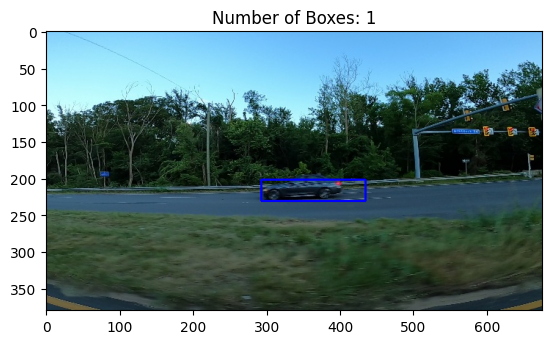

In [ ]:
import tkinter as tk
from tkinter import filedialog


class GUI:
    def __init__(self):

        # Create the window and set properties
        self.root = tk.Tk()
        self.root.title("Cars Object Detection")
        self.root.geometry("800x600")
        self.root.configure(bg="#34495E")  # Set background color

        # Configure a modern and elegant font
        font_style = ("Helvetica", 12)

        # Create app Frames
        self.MainFrame = tk.Frame(self.root, bg="#34495E")
        self.ModelFrame = tk.Frame(self.root, bg="#34495E")
        self.PhotoFrame = tk.Frame(self.root, bg="#34495E")

        # Home Button to get back to MainFrame
        self.home = tk.Button(self.root, text="Home", font=font_style, command=self.Home, bg="#2ECC71", fg="#FFFFFF")
        self.home.place(x=10, y=10, height=40, width=80)

        # model Variable contains the model as a string "ANN" or "CNN"
        self.model = ""

        # Call the main frame to start the app
        self.Make_ModelFrame()

        # Load the app
        self.root.mainloop()

    def set_model_cnn(self):
        self.model = "cnn"
        self.ModelFrame.pack_forget()
        self.Make_MainFrame()
        print("Selected model: CNN")


    def Home(self):
        self.ModelFrame.pack()
        self.MainFrame.pack_forget()
        self.PhotoFrame.pack_forget()

    def Make_MainFrame(self):
        self.MainFrame.configure(bg="#34495E")

        for i in range(4):
            self.MainFrame.grid_rowconfigure(i, weight=1)  # Allow rows to expand vertically
        self.MainFrame.grid_columnconfigure(0, weight=1)  # Allow column to expand horizontally

        # the label on the top
        self.Mainlabel = tk.Label(self.MainFrame, text="Choose Input Type", font=("Arial", 36), bg="#34495E", fg="#FFFFFF")

        '''
            - each button when you click it, Calls the new frame and makes the MainFrame invisible
            - each frame calls the Make_ModelFrame that is responsible for choosing the model
        '''
        self.PhotoButton = tk.Button(self.MainFrame, text="Photo", font=("Arial", 24), command=self.Make_PhotoFrame,
                                     bg="#3498DB", fg="#FFFFFF")


        self.Mainlabel.pack(pady=80)
        self.PhotoButton.pack(pady=30)


        self.MainFrame.pack()

    def Make_ModelFrame(self):
        self.ModelFrame.configure(bg="#34495E")

        self.Modellabel = tk.Label(self.ModelFrame, text="Choose Model", font=("Arial", 36), bg="#34495E", fg="#FFFFFF")

        self.ModelCNN = tk.Button(self.ModelFrame, text="CNN", font=("Arial", 24), command=self.set_model_cnn,
                                  bg="#3498DB", fg="#FFFFFF")

        self.Modellabel.pack(pady=100)
        self.ModelCNN.pack(pady=30)

        self.ModelFrame.pack()

    def open_photo_explorer(self):
        file_path = filedialog.askopenfilename(title="Select Photo",
                                               filetypes=[("Image Files", "*.jpg *.jpeg *.png")])

        # Update the photo path entry with the selected file path
        self.photo_path_entry.configure(state="normal")
        self.photo_path_entry.delete(0, tk.END)
        self.photo_path_entry.insert(0, file_path)
        self.photo_path_entry.configure(state="readonly")

        image_do(file_path)


    def Make_PhotoFrame(self):
        self.MainFrame.pack_forget()

        # Set background color for PhotoFrame
        self.PhotoFrame.configure(bg="#34495E")

        # Button for browsing photo
        self.browse_photo_button = tk.Button(self.PhotoFrame, text="Browse Photo", font=("Arial", 20),
                                             command=self.open_photo_explorer, bg="#3498DB", fg="#FFFFFF")
        self.browse_photo_button.pack(pady=20)

        # Label to display selected photo path
        self.photo_path_label = tk.Label(self.PhotoFrame, text="Selected Photo Path:", font=("Arial", 16),
                                         bg="#34495E", fg="#FFFFFF")
        self.photo_path_label.pack(pady=10)

        # Placeholder for displaying the selected photo path
        self.photo_path_entry = tk.Entry(self.PhotoFrame, font=("Arial", 16), state="normal")
        self.photo_path_entry.pack(pady=10)

        self.PhotoFrame.pack()



GUI()